# Denoising diffusion: MNIST

The training of a DDPM for MNIST data can be launched by running the dedicated Python script in the parent folder. For using the default settings, without any custom modifications of the architecture or the training algorithm, simply run `python train_ddpm_mnist.py`. The training process may then be monitored via `tensorboard --logdir run/mnist/`. Subsequently, the final model is shortly tested in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from lightning.pytorch import seed_everything

from diffusion import DDPM2d

In [3]:
_ = seed_everything(111111) # set random seeds manually

Seed set to 111111


## MNIST data

First of all, let us import the validation data such that they can be easily accessed.

In [4]:
val_set = datasets.MNIST(
    '../run/data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

val_loader = DataLoader(
    val_set,
    batch_size=32,
    drop_last=False,
    shuffle=False
)

In [5]:
x_batch, y_batch = next(iter(val_loader))
image_shape = x_batch.shape[1:]

We may also have a look at some of image samples from the validation set.

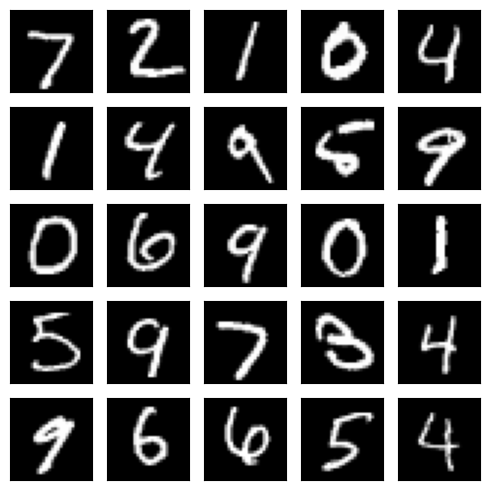

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
for idx, ax in enumerate(axes.ravel()):
    image = x_batch[idx, 0].numpy()
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

## DDPM import

The DDPM with all its architectural hyperparameters and the learned weights is then initialized as follows.

In [7]:
ckpt_file = '../run/mnist/version_0/checkpoints/last.ckpt'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load(ckpt_file, map_location=device)
ddpm = DDPM2d.load_from_checkpoint(ckpt_file)

ddpm = ddpm.eval()
ddpm = ddpm.to(device)

For the sake of completeness, the used noise schedule is plotted.

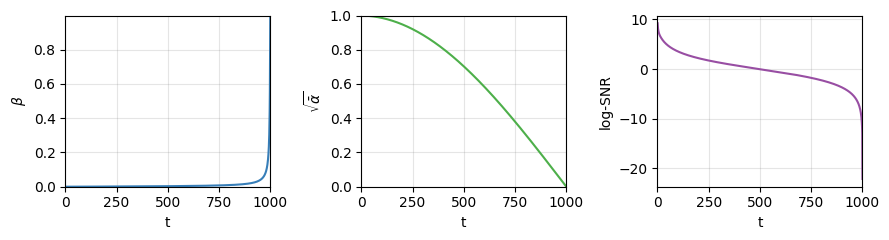

In [8]:
betas = ddpm.betas.cpu().numpy()
alphas_bar = ddpm.alphas_bar.cpu().numpy()
log_snr = np.log(alphas_bar / (1 - alphas_bar))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 2.5))

ax1.plot(np.arange(len(betas)) + 1, betas, color=plt.cm.Set1(1))
ax1.set(xlim=(0, len(ddpm.betas)), ylim=(0, ddpm.betas.max().item()))
ax1.set(xlabel='t', ylabel='$\\beta$')
ax1.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax1.set_axisbelow(True)

ax2.plot(np.arange(len(alphas_bar)) + 1, np.sqrt(alphas_bar), color=plt.cm.Set1(2))
ax2.set(xlim=(0, len(ddpm.alphas_bar)), ylim=(0, 1))
ax2.set(xlabel='t', ylabel='$\\sqrt{\\bar{\\alpha}}$')
ax2.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax2.set_axisbelow(True)

ax3.plot(np.arange(len(log_snr)) + 1, log_snr, color=plt.cm.Set1(3))
ax3.set(xlim=(0, len(ddpm.alphas_bar)))
ax3.set(xlabel='t', ylabel='log-SNR')
ax3.grid(visible=True, which='both', color='gray', alpha=0.2, linestyle='-')
ax3.set_axisbelow(True)

fig.tight_layout()

Also the non-learnable component of the temporal embedding (of an arbitrary model layer) is visualized.

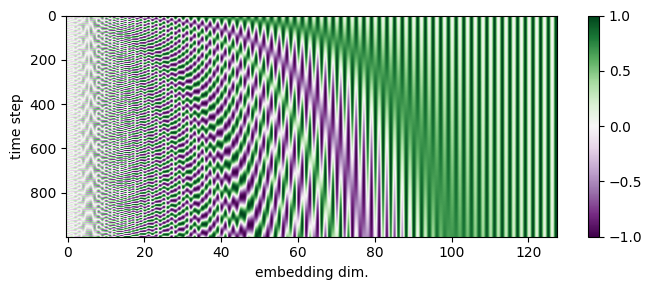

In [9]:
sinusoidal_encoding = ddpm.eps_model.encoder.first_conv.emb[0]
tids = torch.arange(ddpm.num_steps).view(-1, 1)
ts = tids + 1 # note that tidx = 0 corresponds to t = 1.0
encs = sinusoidal_encoding(ts.to(device)).cpu()

fig, ax = plt.subplots(figsize=(7, 3))
img = ax.imshow(encs.numpy(), cmap='PRGn', aspect='auto')
ax.set(xlabel='embedding dim.', ylabel='time step')
fig.colorbar(img)
fig.tight_layout()

## Forward process

Starting from an image sample, the forward diffusion gradually diffuses it into mere noise.

In [10]:
x_noisy = ddpm.diffuse_all_steps(x_batch.to(device)).cpu()

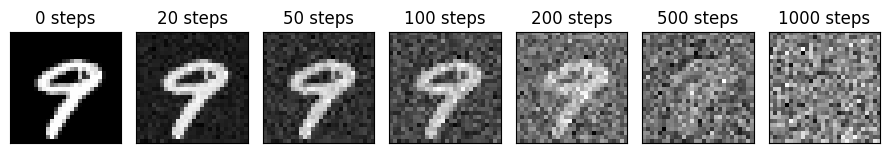

In [11]:
plot_steps = [0, 20, 50, 100, 200, 500, 1000]

sample_idx = np.random.randint(x_noisy.shape[1]) # select random sample from batch

fig, axes = plt.subplots(nrows=1, ncols=len(plot_steps), figsize=(9, 2))
for time_idx, ax in zip(plot_steps, axes.ravel()):
    image = x_noisy[time_idx, sample_idx, 0].numpy()
    ax.imshow(image, cmap='gray')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

## Generative process

The reverse process generates new data by denoising pure random noise in stepwise fashion.

In [12]:
x_noise = torch.randn(16, *image_shape)
x_denoise = ddpm.denoise_all_steps(x_noise.to(device)).cpu()

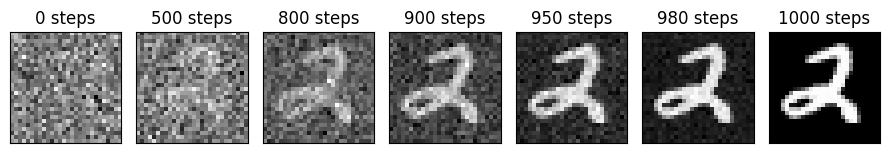

In [13]:
reverse_plot_steps = [ddpm.num_steps - s for s in reversed(plot_steps)]

sample_idx = np.random.randint(x_denoise.shape[1]) # select random sample from batch

fig, axes = plt.subplots(nrows=1, ncols=len(reverse_plot_steps), figsize=(9, 2))
for time_idx, ax in zip(reverse_plot_steps, axes.ravel()):
    image = x_denoise[time_idx, sample_idx, 0].numpy()
    ax.imshow(image, cmap='gray')
    ax.set_title('{} steps'.format(time_idx))
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

An ensemble of images generated this way is shown below.

In [14]:
x_gen = ddpm.generate(sample_shape=image_shape, num_samples=25).cpu()

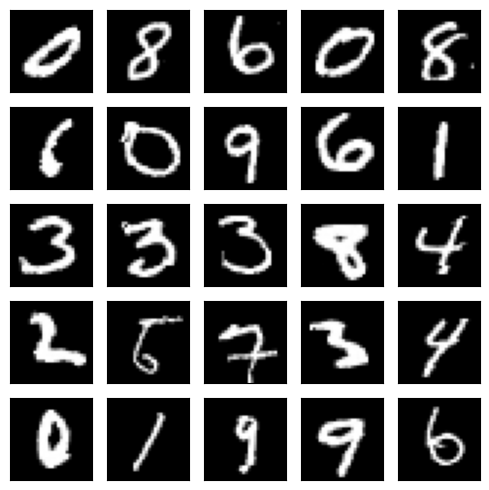

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
for idx, ax in enumerate(axes.ravel()):
    image = x_gen[idx, 0].numpy()
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.tight_layout()

Not perfect, but also not so bad after all. There are certainly many opportunities for improvement. In this context, it would be helpful to better understand the relationship between the value of the loss function and the visual image quality in the future.